In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import random


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 32

captions_path = 'text_c10'
img_name_path = 'images.txt'
data_path = 'images/'

word_counts = defaultdict(float)

In [2]:
name_id = open(img_name_path).read().splitlines()
name2id_train = {}
id2name_train = {}
for index, img in enumerate (name_id):
        name2id_train[img.split(' ')[1]] = img.split(' ')[0]
        id2name_train[img.split(' ')[0]] = img.split(' ')[1]

id2caption_train = {}

for name in name2id_train:
    txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
    txt_path = os.path.join(captions_path, txt_name)
    idx = name2id_train[name]
    id2caption_train[idx] = open(txt_path,  encoding='utf-8').read().splitlines()

In [3]:
all_captions =[]
from nltk.tokenize import RegexpTokenizer
for i, captions in enumerate(id2caption_train.values()):
    for cap in captions:
        if len(cap) == 0:
            continue
        cap = cap.replace(u"\ufffd\ufffd", u" ")

        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(cap.lower())

        if len(tokens) == 0:
            print('cap', cap)
            continue

        tokens_new = []
        for t in tokens:
            t = t.encode('ascii', 'ignore').decode('ascii')
            if len(t) > 0:
                tokens_new.append(t)
        all_captions.append(tokens_new)
        
word_counts = defaultdict(float)
captions = all_captions
for sent in captions:
    for word in sent:
        word_counts[word] += 1

vocab = [w for w in word_counts if word_counts[w] >= 0]

ixtoword = {}
ixtoword[0] = '<end>'
wordtoix = {}
wordtoix['<end>'] = 0
ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [4]:
print(len(wordtoix))

5450


In [5]:
class DataLoader:
    def __init__(self):
        self.device = device
        self.batch_size = batch_size
        self.data_path = data_path
        name_id = open(img_name_path).read().splitlines()
        
#         random.shuffle(name_id)
        
        name2id_train = {}
        id2name_train = {}
        name2id_test = {}
        id2name_test = {}
        for index, img in enumerate (name_id):
            if(len(name2id_train) < 9430):
                name2id_train[img.split(' ')[1]] = img.split(' ')[0]
                id2name_train[img.split(' ')[0]] = img.split(' ')[1]
            else:
                name2id_test[img.split(' ')[1]] = img.split(' ')[0]
                id2name_test[img.split(' ')[0]] = img.split(' ')[1]
       
        id2caption_train = {}
        id2caption_test = {}
        
        for name in name2id_train:
            txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
            txt_path = os.path.join(captions_path, txt_name)
            idx = name2id_train[name]
            id2caption_train[idx] = open(txt_path,  encoding='utf-8').read().splitlines()
        
        for name in name2id_test:
            txt_name = '.'.join(name.split('.')[0:-1]) + '.txt'
            txt_path = os.path.join(captions_path, txt_name)
            idx = name2id_test[name]
            id2caption_test[idx] = open(txt_path,  encoding='utf-8').read().splitlines()
        
        self.name2id_train = name2id_train
        self.id2name_train = id2name_train
        self.name2id_test = name2id_test
        self.id2name_test = id2name_test
        
        self.id2caption_train = id2caption_train
        self.id2caption_test = id2caption_test
        
        self.data_transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize([256, 256]),
#                 torchvision.transforms.CenterCrop(256),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

#         self.text_transforms = torchvision.transforms.Compose([
# #             torchvision.transforms.ToTensor()
#             #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         ])
        
    def load_img(self, image_name):
        image = Image.open(image_name)
        image = self.data_transforms(image).float()
        image = torch.autograd.Variable(image, requires_grad=False)
        image = image.unsqueeze(0)
        return image[0].to(device)
    
    def imshow(self, img):
        img = img / 2 + 0.5     # unnormalize
        npimg = img.cpu().detach().numpy()
        plt.figure(figsize = (5,5))
        plt.imshow(np.transpose(npimg, (1, 2, 0)), aspect='auto')
        
    def padding(self, unpadded):
        l = []
        for i in unpadded:
            for j in i:
                l.append([len(j)])
        lens = np.array(l)   
        mask = lens[:,None] > np.arange(lens.max())
        out = np.full(mask.shape,0)
        out[mask] = np.concatenate(np.concatenate(unpadded))
        out = out.reshape(len(unpadded),10,-1)
        return torch.LongTensor(out)
    
    def get_data(self, train=True):
        if train == True:
            images = self.id2name_train
            lb = self.id2caption_train
        else:
            images = self.test_id2name_test
            lb = self.id2caption_test
        while True:
            ix = np.random.choice(np.arange(len(images)), self.batch_size)
            x = []
            z = []
#             print(ix)
            for i in ix:
#                 print(images[str(i)])
#                 print(lb[str(i)])
                x.append(self.load_img(self.data_path + images[str(i)]))
                            
                tmp = []
                for cap in lb[str(i)]:
                    if len(cap) == 0:
                        continue
                    cap = cap.replace(u"\ufffd\ufffd", u" ")
                    tokenizer = RegexpTokenizer(r'\w+')
                    tokens = tokenizer.tokenize(cap.lower())

                    if len(tokens) == 0:
                        print('cap', cap)
                        continue

                    tokens_new = []
                    for t in tokens:
                        t = t.encode('ascii', 'ignore').decode('ascii')
                        if len(t) > 0:
                            tokens_new.append(t)
                    tmp.append(tokens_new)

                train_captions_new = []
                for t in tmp:
                    rev = []
                    for w in t:
                        if w in wordtoix:
                            rev.append(wordtoix[w])
                    train_captions_new.append(rev)
                z.append(train_captions_new)
            yield torch.stack(x), self.padding(z).to(device), list(ix)
            
loader = DataLoader()
x, y, class_ids = next(loader.get_data(True))

torch.Size([32, 3, 256, 256])
torch.Size([32, 10, 34])
[720, 8947, 8502, 7834, 5757, 7456, 7346, 8073, 415, 8293, 9026, 1376, 6855, 6231, 945, 4253, 2526, 9065, 840, 4812, 1734, 4176, 4622, 2581, 7847, 803, 5989, 5809, 586, 7299, 1152, 2162]


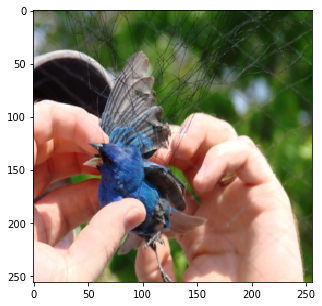

In [6]:
print(x.shape)
loader.imshow(x[0])
print(y.shape)
print(class_ids)

In [7]:
caption = y[:,np.random.randint(0,10),:]
caption.shape

torch.Size([32, 34])

In [8]:
class RNN_ENCODER(nn.Module):
    def __init__(self, ntoken, ninput=300, drop_prob=0.5,
                 nhidden=128, nlayers=1, bidirectional=True):
        super(RNN_ENCODER, self).__init__()
        
        self.ntoken = ntoken  # size of the dictionary
        self.ninput = ninput  # size of each embedding vector
        self.drop_prob = drop_prob  # probability of an element to be zeroed
        self.nlayers = nlayers  # Number of recurrent layers
        self.bidirectional = bidirectional

        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1

        self.nhidden = nhidden // self.num_directions

        self.encoder = nn.Embedding(self.ntoken, self.ninput)
        self.drop = nn.Dropout(self.drop_prob)
        
        self.rnn = nn.LSTM(self.ninput, self.nhidden,
                           self.nlayers, batch_first=True,
                           dropout=self.drop_prob,
                           bidirectional=self.bidirectional)


    def init_hidden(self, batch_size):
        return (torch.zeros(self.nlayers* self.num_directions, batch_size, self.nhidden).cuda(),
                torch.zeros(self.nlayers* self.num_directions, batch_size, self.nhidden).cuda())

    def forward(self, captions):
    
        emb = self.drop(self.encoder(captions))
#         print(self.encoder(captions))
        
        output, self.hidden = self.rnn(emb, self.hidden)
        words_emb = output.transpose(1, 2)
        
        sent_emb = self.hidden[0].transpose(0, 1).contiguous()
        sent_emb = sent_emb.view(-1, self.nhidden * self.num_directions)
        
        return words_emb, sent_emb


In [9]:
model = RNN_ENCODER(ntoken = 5450).to(device)
model.hidden = model.init_hidden(batch_size)
word_emb, sent_emb = model.forward(caption)
print(word_emb.shape, sent_emb.shape)

torch.Size([32, 128, 34]) torch.Size([32, 128])


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [12]:
from torchvision import models
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F

In [13]:
class CNN_ENCODER(nn.Module):
    def __init__(self, nef):
        super(CNN_ENCODER, self).__init__()
        self.nef = 128  # define a uniform ranker

        model = models.inception_v3().to(device)
        url = 'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth'
        model.load_state_dict(model_zoo.load_url(url))
        for param in model.parameters():
            param.requires_grad = False
        print('Load pretrained model from ', url)
        self.define_module(model)
        self.init_trainable_weights()

    def define_module(self, model):
        self.Conv2d_1a_3x3 = model.Conv2d_1a_3x3
        self.Conv2d_2a_3x3 = model.Conv2d_2a_3x3
        self.Conv2d_2b_3x3 = model.Conv2d_2b_3x3
        self.Conv2d_3b_1x1 = model.Conv2d_3b_1x1
        self.Conv2d_4a_3x3 = model.Conv2d_4a_3x3
        self.Mixed_5b = model.Mixed_5b
        self.Mixed_5c = model.Mixed_5c
        self.Mixed_5d = model.Mixed_5d
        self.Mixed_6a = model.Mixed_6a
        self.Mixed_6b = model.Mixed_6b
        self.Mixed_6c = model.Mixed_6c
        self.Mixed_6d = model.Mixed_6d
        self.Mixed_6e = model.Mixed_6e
        self.Mixed_7a = model.Mixed_7a
        self.Mixed_7b = model.Mixed_7b
        self.Mixed_7c = model.Mixed_7c

        self.emb_features = conv1x1(768, self.nef)
        self.emb_cnn_code = nn.Linear(2048, self.nef)

    def init_trainable_weights(self):
        initrange = 0.1
        self.emb_features.weight.data.uniform_(-initrange, initrange)
        self.emb_cnn_code.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        features = None
        # --> fixed-size input: batch x 3 x 299 x 299

        x = nn.Upsample(size=(299, 299), mode='bilinear')(x)
        # 299 x 299 x 3
        x = self.Conv2d_1a_3x3(x)
        # 149 x 149 x 32
        x = self.Conv2d_2a_3x3(x)
        # 147 x 147 x 32
        x = self.Conv2d_2b_3x3(x)
        # 147 x 147 x 64
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 73 x 73 x 64
        x = self.Conv2d_3b_1x1(x)
        # 73 x 73 x 80
        x = self.Conv2d_4a_3x3(x)
        # 71 x 71 x 192

        x = F.max_pool2d(x, kernel_size=3, stride=2)
        # 35 x 35 x 192
        x = self.Mixed_5b(x)
        # 35 x 35 x 256
        x = self.Mixed_5c(x)
        # 35 x 35 x 288
        x = self.Mixed_5d(x)
        # 35 x 35 x 288

        x = self.Mixed_6a(x)
        # 17 x 17 x 768
        x = self.Mixed_6b(x)
        # 17 x 17 x 768
        x = self.Mixed_6c(x)
        # 17 x 17 x 768
        x = self.Mixed_6d(x)
        # 17 x 17 x 768
        x = self.Mixed_6e(x)
        # 17 x 17 x 768

        # image region features
        features = x
        # 17 x 17 x 768
        x = self.Mixed_7a(x)
        # 8 x 8 x 1280
        x = self.Mixed_7b(x)
        # 8 x 8 x 2048
        x = self.Mixed_7c(x)
        # 8 x 8 x 2048
        x = F.avg_pool2d(x, kernel_size=8)
        # 1 x 1 x 2048
        # x = F.dropout(x, training=self.training)
        # 1 x 1 x 2048
        x = x.view(x.size(0), -1)
        # 2048
        # global image features
        cnn_code = self.emb_cnn_code(x)
        # 512
        if features is not None:
            features = self.emb_features(features)
        return features, cnn_code

In [ ]:
image_encoder = CNN_ENCODER(128).to(device)

In [ ]:
 img_features, img_sent_code = image_encoder(x)

In [ ]:
print(word_emb.shape, sent_emb.shape, img_features.shape, img_sent_code.shape)
from torch.autograd import Variable
label = Variable(torch.LongTensor(range(batch_size))).cuda()

In [ ]:
def func_attention(query, context, gamma1):
    """
    query: batch x ndf x queryL
    context: batch x ndf x ih x iw (sourceL=ihxiw)
    mask: batch_size x sourceL
    """
    batch_size, queryL = query.size(0), query.size(2)
    ih, iw = context.size(2), context.size(3)
    sourceL = ih * iw

    # --> batch x sourceL x ndf
    context = context.view(batch_size, -1, sourceL)
    contextT = torch.transpose(context, 1, 2).contiguous()

    # Get attention
    # (batch x sourceL x ndf)(batch x ndf x queryL)
    # -->batch x sourceL x queryL
    attn = torch.bmm(contextT, query) # Eq. (7) in AttnGAN paper
    # --> batch*sourceL x queryL
    attn = attn.view(batch_size*sourceL, queryL)
    attn = nn.Softmax()(attn)  # Eq. (8)

    # --> batch x sourceL x queryL
    attn = attn.view(batch_size, sourceL, queryL)
    # --> batch*queryL x sourceL
    attn = torch.transpose(attn, 1, 2).contiguous()
    attn = attn.view(batch_size*queryL, sourceL)
    #  Eq. (9)
    attn = attn * gamma1
    attn = nn.Softmax()(attn)
    attn = attn.view(batch_size, queryL, sourceL)
    # --> batch x sourceL x queryL
    attnT = torch.transpose(attn, 1, 2).contiguous()

    # (batch x ndf x sourceL)(batch x sourceL x queryL)
    # --> batch x ndf x queryL
    weightedContext = torch.bmm(context, attnT)
    
    return weightedContext, attn.view(batch_size, -1, ih, iw)


def cosine_similarity(x1, x2, dim=1, eps=1e-8):
    """Returns cosine similarity between x1 and x2, computed along dim.
    """
    w12 = torch.sum(x1 * x2, dim)
    w1 = torch.norm(x1, 2, dim)
    w2 = torch.norm(x2, 2, dim)
    return (w12 / (w1 * w2).clamp(min=eps)).squeeze()


def words_loss(img_features, words_emb, labels, batch_size, class_ids):
    """
        words_emb(query): batch x nef x seq_len
        img_features(context): batch x nef x 17 x 17
    """
    masks = []
    att_maps = []
    similarities = []
    for i in range(batch_size):
        if class_ids is not None:
            mask = (class_ids != class_ids[i]).astype(np.uint8)
            masks.append(mask.reshape((1, -1)))
                
        words_num = word_emb.shape[2]
        
        # -> 1 x nef x words_num
        word = words_emb[i, :, :words_num].unsqueeze(0).contiguous()
        # -> batch_size x nef x words_num
        word = word.repeat(batch_size, 1, 1)
        # batch x nef x 17*17
        context = img_features
        """
            word(query): batch x nef x words_num
            context: batch x nef x 17 x 17
            weiContext: batch x nef x words_num
            attn: batch x words_num x 17 x 17
        """
        weiContext, attn = func_attention(word, context,5)

        att_maps.append(attn[i].unsqueeze(0).contiguous())
        # --> batch_size x words_num x nef
        word = word.transpose(1, 2).contiguous()
        weiContext = weiContext.transpose(1, 2).contiguous()
        # --> batch_size*words_num x nef
        word = word.view(batch_size * words_num, -1)
        weiContext = weiContext.view(batch_size * words_num, -1)
        
        # -->batch_size*words_num
        row_sim = cosine_similarity(word, weiContext)
        # --> batch_size x words_num
        row_sim = row_sim.view(batch_size, words_num)

        # Eq. (10)
        row_sim.mul_(5).exp_()
        row_sim = row_sim.sum(dim=1, keepdim=True)
        row_sim = torch.log(row_sim)

        # --> 1 x batch_size
        # similarities(i, j): the similarity between the i-th image and the j-th text description
        similarities.append(row_sim)

    # batch_size x batch_size
    similarities = torch.cat(similarities, 1)

    if class_ids is not None:
        masks = np.concatenate(masks, 0)
        # masks: batch_size x batch_size
        masks = torch.ByteTensor(masks).cuda()

    similarities = similarities * 10

    if class_ids is not None:
        similarities.data.masked_fill_(masks, -float('inf'))
        
    similarities1 = similarities.transpose(0, 1)

    if labels is not None:
        loss0 = nn.CrossEntropyLoss()(similarities, labels)
        loss1 = nn.CrossEntropyLoss()(similarities1, labels)
    else:
        loss0, loss1 = None, None
    return loss0, loss1, att_maps

w_loss0, w_loss1, attn_maps = words_loss(img_features, word_emb, label, batch_size, class_ids)